# Neural Networks

## Introduction

This assignement focuses on implementing and analyzing a neural network model for image segmentation. The goal is to classify each pixel in an image as either foreground or background. The data consists of training and test images with corresponding segmentation maps, where pixels are labeled as 1 (foreground) or 0 (background).

The tasks are going to involve implementing and training a neural network using various methods:

- A simple logistic regression classifier implementation, using pixel intensities as input features and fixed cosine basis functions for feature transformation.
- The effect of intensity transformations on segmentation accuracy is going be studied to evaluate the model's robustness to input variations.
- Adaptive basis functions are going to be introduced to allow the model to learn more flexible feature representations.
- Spatial context is going to be incorporated by including neighboring pixel intensities as input features, improving the model's ability to handle complex patterns.
- Larger input patches (3 × 3) are going to be used to further enhance spatial awareness, with the learned feature maps and weights visualized.

This report includes model implementation, training results, segmentation outputs, and critical analysis of model behavior for each task. This stepwise approach provides insights into how different design choices affect segmentation performance.

### Input data and code hints
Import Python libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<font size="5">Initialization</font>

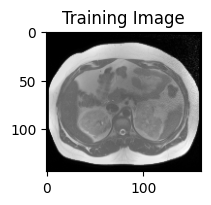

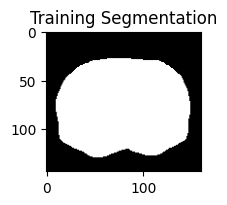

In [2]:
M = 6
noOfSamples = 200
vm = 0.005
numIter = 5000

# Load data
clip0 = np.load('dataForNN_inside_clip0.npy', allow_pickle=True).tolist()

TI = clip0['trainingImage']
TS = clip0['trainingSegmentation']
TestI = clip0['testImage']
TestS = clip0['testSegmentation']

# Show image
plt.figure(figsize=(2,2))
plt.imshow(clip0['trainingImage'], cmap='gray')
plt.title('Training Image')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(clip0['trainingSegmentation'], cmap='gray')
plt.title('Training Segmentation')
plt.show()

## Task 1: Pixel-wise logistic regression classifier

For the data file ```dataForNN_inside_clip0.mat``` implement a pixel-wise logistic regression classifier $p(l \vert d, \theta)$, using fixed basis functions of the form

$$ \phi_m (d) = \cos[\pi(m-1)d] $$

You can use $\hat{w}_m = 0, \forall m$ for initializing the stochastic gradient descent algorithm.

Include in your report:
- a plot of the evolution of the cross-entropy across iterations
- the final segmentation of the test image
- the quantity $a$ and the obtained classifier (as in figure ...)
- visualization of where training samples are located (e.g. show $N^{\prime}$ samples of the last iteration of the stochastic gradient descent algorithm)

The following functions are provided:

    getInputFeatures(), getSamples(), showLocationOfSamples(), plotSeg()

In [3]:
def getInputFeatures(image, numberOfNeighbors, shift=1):
    numberOfFeatures = numberOfNeighbors + 1

    leftNeighborImage = np.zeros_like(image)
    leftNeighborImage[:, shift:] = image[:, :-shift]

    rightNeighborImage = np.zeros_like(image)
    rightNeighborImage[:, :-shift] = image[:, shift:]

    topNeighborImage = np.zeros_like(image)
    topNeighborImage[shift:, :] = image[:-shift, :]

    bottomNeighborImage = np.zeros_like(image)
    bottomNeighborImage[:-shift, :] = image[shift:, :]

    leftTopNeighborImage = np.zeros_like(image)
    leftTopNeighborImage[shift:, shift:] = image[:-shift, :-shift]

    rightTopNeighborImage = np.zeros_like(image)
    rightTopNeighborImage[shift:, :-shift] = image[:-shift, shift:]

    leftBottomNeighborImage = np.zeros_like(image)
    leftBottomNeighborImage[:-shift, shift:] = image[shift:, :-shift]

    rightBottomNeighborImage = np.zeros_like(image)
    rightBottomNeighborImage[:-shift, :-shift] = image[shift:, shift:]

    if numberOfNeighbors == 0:
        features = image.ravel()
    elif numberOfNeighbors == 1:
        features = np.column_stack((image.ravel(), bottomNeighborImage.ravel()))
    elif numberOfNeighbors == 4:
        features = np.column_stack((
            image.ravel(),
            leftNeighborImage.ravel(),
            rightNeighborImage.ravel(),
            topNeighborImage.ravel(),
            bottomNeighborImage.ravel()
        ))
    elif numberOfNeighbors == 8:
        features = np.column_stack((
            image.ravel(),
            leftTopNeighborImage.ravel(),
            topNeighborImage.ravel(),
            rightTopNeighborImage.ravel(),
            leftNeighborImage.ravel(),
            rightNeighborImage.ravel(),
            leftBottomNeighborImage.ravel(),
            bottomNeighborImage.ravel(),
            rightBottomNeighborImage.ravel()
        ))
    else:
        raise NotImplementedError("Number of neighbors not implemented yet")

    featureImage = features.reshape((image.shape[0], image.shape[1], numberOfFeatures))
    return featureImage

def getSamples(featureImage, segmentation, numberOfSamples, mask=None):
    if mask is None:
        mask = np.ones(segmentation.shape)

    numberOfFeatures = featureImage.shape[2]
    numberOfPixels = featureImage.shape[0] * featureImage.shape[1]

    numberOfSamplesPerClass = int(np.ceil(numberOfSamples / 2))
    x = np.zeros((numberOfSamplesPerClass, numberOfFeatures, 2))
    t = np.zeros((numberOfSamplesPerClass, 2))
    rowAndColNumbers = np.zeros((numberOfSamplesPerClass, 2, 2))

    oneHotEncoding = np.zeros((segmentation.shape[0], segmentation.shape[1], 2))
    oneHotEncoding[:, :, 0] = segmentation
    oneHotEncoding[:, :, 1] = 1 - segmentation

    rows, cols = np.meshgrid(np.arange(1, featureImage.shape[0] + 1),
                             np.arange(1, featureImage.shape[1] + 1))

    for k in range(2):
        indices = np.where(oneHotEncoding[:, :, k] * mask)
        sampleIndices = np.random.choice(len(indices[0]), numberOfSamplesPerClass, replace=False)
        indices = (indices[0][sampleIndices], indices[1][sampleIndices])

        x[:, :, k] = featureImage[indices[0], indices[1]]
        t[:, k] = segmentation[indices[0], indices[1]]
        rowAndColNumbers[:, :, k] = np.stack((indices[0], indices[1]), axis=1)

    x = np.concatenate((x[:, :, 0], x[:, :, 1]), axis=0)
    t = np.concatenate((t[:, 0], t[:, 1]), axis=0)
    rowAndColNumbers = np.concatenate((rowAndColNumbers[:, :, 0], rowAndColNumbers[:, :, 1]), axis=0)

    x = x[:numberOfSamples, :]
    t = t[:numberOfSamples]
    rowAndColNumbers = rowAndColNumbers[:numberOfSamples, :]

    return x, t, rowAndColNumbers

def showLocationOfSamples(image, rowAndColNumbers, t):
    colors = ['b', 'r']
    markers = ['o', 'x']

    plt.imshow(image, cmap='gray')
    T = np.zeros([rowAndColNumbers.shape[0], 2])
    T[:,0] = t
    T[:,1] = t-1
    for k in range(2):
        tmp = rowAndColNumbers[np.where(T[:, k]), :]
        marker = markers[k]
        color = colors[k]
        plt.scatter(tmp[:,:,1], tmp[:,:,0], marker=marker, color=color, linewidth=0.75)
    
    plt.show

def plotSeg(image, segmentation):
    tmp = np.zeros((segmentation.shape[0], segmentation.shape[1], 3))
    tmp[:, :, 0] = 1 - segmentation
    tmp[:, :, 2] = segmentation
    plt.imshow(image, cmap='gray')
    plt.imshow(tmp, alpha = 0.5)


Iteration 0/5000, Cross-Entropy: 0.6931
Iteration 500/5000, Cross-Entropy: 0.3711
Iteration 1000/5000, Cross-Entropy: 0.2663
Iteration 1500/5000, Cross-Entropy: 0.1880
Iteration 2000/5000, Cross-Entropy: 0.1524
Iteration 2500/5000, Cross-Entropy: 0.1393
Iteration 3000/5000, Cross-Entropy: 0.1535
Iteration 3500/5000, Cross-Entropy: 0.0908
Iteration 4000/5000, Cross-Entropy: 0.1111
Iteration 4500/5000, Cross-Entropy: 0.0930


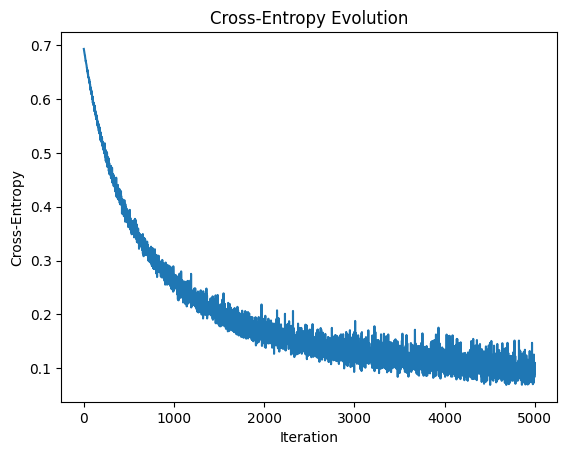

In [4]:
# Define the cross-entropy loss function
def cross_entropy(y_pred, y_true):
    """Compute cross-entropy loss."""
    epsilon = 1e-12  # Small value to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Ensure predictions are within valid range
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Train logistic regression using SGD
def train_logistic_regression(TI, TS, M, numN, numIter, vm, noOfSamples):
    """Train the logistic regression model using SGD."""
    # Extract features from the training image
    featureImage = getInputFeatures(TI, numN)

    # Initialize theta
    numFeatures = numN + 1
    theta = np.zeros(M * numFeatures)

    # Track cross-entropy history
    cross_entropy_history = []

    for iteration in range(numIter):
        # Get samples from the training image and segmentation
        x, t, rowAndColNumbers = getSamples(featureImage, TS, noOfSamples)

        # Compute basis functions for the sampled data
        phi = np.array([
            np.cos(np.pi * (m - 1) * x[:, j])
            for m in range(1, M + 1)
            for j in range(numFeatures)
        ]).T

        # Logistic regression predictions
        a = phi @ theta
        y_pred = 1 / (1 + np.exp(-a))

        # Compute cross-entropy loss
        cost = cross_entropy(y_pred, t)

        # Gradient computation using finite differences
        gradient = np.zeros_like(theta)
        for m in range(len(theta)):
            theta_temp = theta.copy()
            theta_temp[m] += 1e-5  # Small delta for finite difference
            new_cost = cross_entropy(1 / (1 + np.exp(-(phi @ theta_temp))), t)
            gradient[m] = (new_cost - cost) / 1e-5

        # Update theta
        theta -= vm * gradient

        # Store cross-entropy loss
        cross_entropy_history.append(cost)

        # Print progress every 500 iterations
        if iteration % 500 == 0:
            print(f"Iteration {iteration}/{numIter}, Cross-Entropy: {cost:.4f}")

    # Compute a_all and p_all after training
    intensity_range = np.linspace(np.min(TI), np.max(TI), 500)
    phi_all = np.array([np.cos(np.pi * (m - 1) * intensity_range) for m in range(1, M + 1)]).T

    theta_reshaped = theta.reshape(M, -1)

    a_all = phi_all @ theta_reshaped[:, 0]  # Activation a for all intensities
    p_all = 1 / (1 + np.exp(-a_all))  # Classifier output (sigmoid)

    return theta, cross_entropy_history, rowAndColNumbers, t, a_all, p_all, phi_all, intensity_range, x

numberOfNeighbors = 0

# Train the model
theta, cross_entropy_history, rowAndColNumbers, t, a_all, p_all, phi, intensity_range, x = train_logistic_regression(TI, TS, M, numberOfNeighbors, numIter, vm, noOfSamples)

# Plot Cross-Entropy Evolution
plt.plot(cross_entropy_history)
plt.title("Cross-Entropy Evolution")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy")
plt.show()

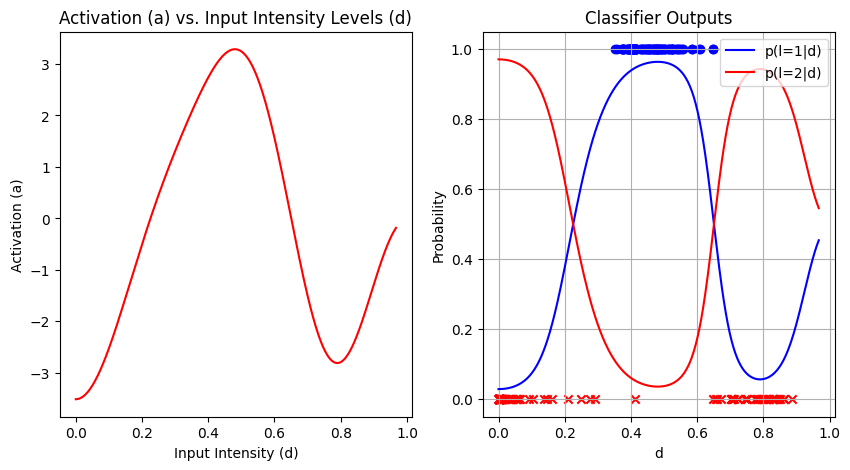

In [5]:
# Plot activation (a) vs. input intensity levels (d)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(intensity_range, a_all, color='red')
plt.title("Activation (a) vs. Input Intensity Levels (d)")
plt.xlabel("Input Intensity (d)")
plt.ylabel("Activation (a)")

# Classifier Outputs
plt.subplot(1, 2, 2)
plt.plot(intensity_range, p_all, color="blue", label="p(l=1|d)")
plt.plot(intensity_range, 1 - p_all, color="red", label="p(l=2|d)")

# Overlay the training samples
training_intensities = x.flatten()
training_labels = t.flatten()
plt.scatter(training_intensities[training_labels == 1], np.ones_like(training_intensities[training_labels == 1]),
            color="blue", marker="o")
plt.scatter(training_intensities[training_labels == 0], np.zeros_like(training_intensities[training_labels == 0]),
            color="red", marker="x")

plt.title("Classifier Outputs")
plt.xlabel("d")
plt.ylabel("Probability")
# plot the legend on the upper left corner
plt.legend(loc="upper right")
plt.grid()

In [6]:
# Segment the test image using trained theta
def segment_test_image(test_image, theta, M, numN):
    """Segment the test image using the trained logistic regression model."""
    # Extract features from the test image
    numFeatures = numN + 1  # Total number of features
    test_features = getInputFeatures(test_image, numN).reshape(-1, numFeatures)  # Shape: (N_pixels, numFeatures)

    # Compute basis functions for all features
    phi_test = np.array([
        np.cos(np.pi * (m - 1) * test_features[:, j])
        for m in range(1, M + 1)
        for j in range(numFeatures)
    ]).T  # Shape: (N_pixels, M * numFeatures)

    # Reshape theta to separate weights for each feature
    # theta_reshaped = theta.reshape(M, numFeatures)  # Shape: (M, numFeatures)

    # Logistic regression predictions
    a_test = phi_test @ theta.ravel()  # Combine all basis functions and features
    y_pred_test = 1 / (1 + np.exp(-a_test))  # Sigmoid activation

    # Reshape predictions into the image shape
    segmentation = y_pred_test.reshape(test_image.shape)
    return segmentation

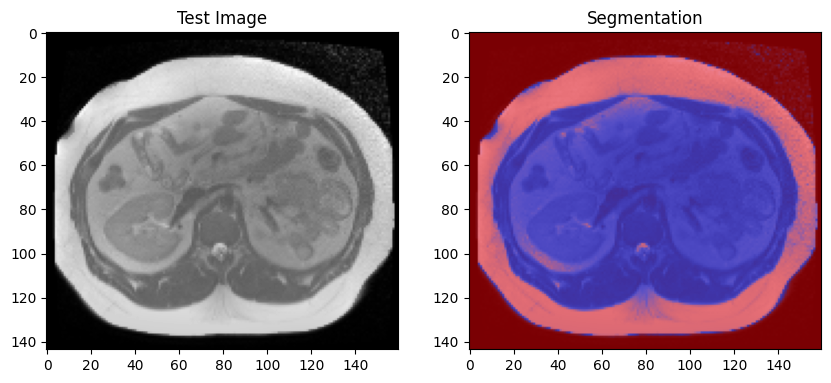

In [7]:
# Perform segmentation on the test image
test_segmentation = segment_test_image(TestI, theta, M, numberOfNeighbors)

# plotting
plt.figure(figsize=(10, 5))

# plot of the image
plt.subplot(1, 2, 1)
plt.imshow(TestI, cmap='gray')
plt.title("Test Image")

# plot of the segmentation
plt.subplot(1, 2, 2)
plotSeg(TestI, test_segmentation)
plt.title("Segmentation")
plt.show()

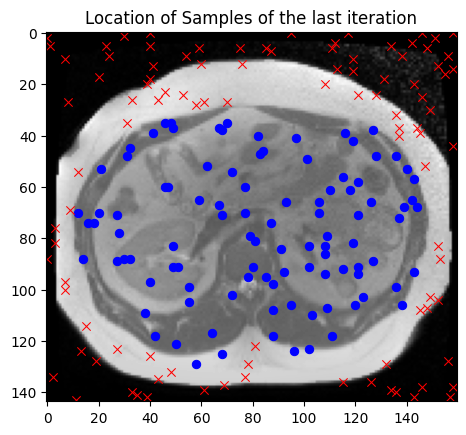

In [8]:
# Show the location of the samples
showLocationOfSamples(TestI, rowAndColNumbers, t)
plt.title("Location of Samples of the last iteration")
plt.show()

In the first task we used a simple logistic regression model to classify each pixel as either foreground or background based on its intensity. The model was trained using a method called 'stochastic gradient descent', that gradually improved accuracy by minimizing errors. We used special mathematical functions - cosine basis functions to process the pixel intensities. The model worked well on the test image, separating the foreground and background clearly, but it didn’t consider neighboring pixels, which could limit its ability to handle more complex images.

## Task 2: Manipulate Intensities in Test Image

Create a new test image by replacing the intensities in the original test image using the rule
$$ d_{new} = d^{1.3}. $$

Use the classifier trained above to segment this new test image.

In your report, reflect on the result you obtain. Do the two test images look similar? What about their segmentations?

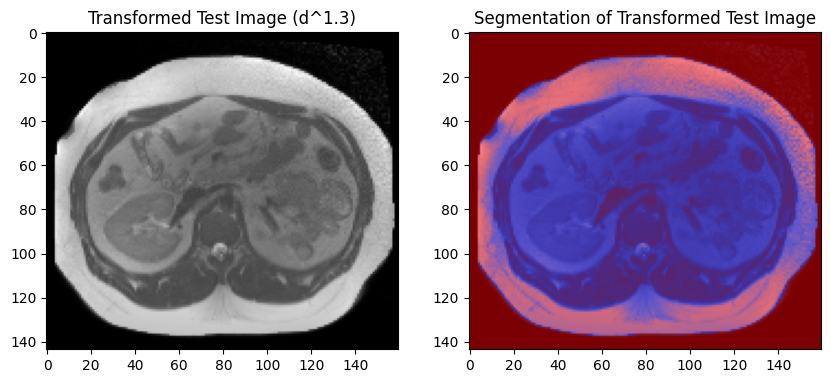

In [9]:
# Transform the test image
def transform_image(image, power=1.3):
    """Apply the transformation d_new = d^1.3."""
    transformed_image = np.power(image, power)
    transformed_image = np.clip(transformed_image, 0, 1)  # Ensure values are within [0, 1]
    return transformed_image

# Apply transformation to the test image
TestI_transformed = transform_image(TestI)

# Perform segmentation on the transformed test image
test_segmentation_transformed = segment_test_image(TestI_transformed, theta, M, numberOfNeighbors)

# Visualize the transformed test image and segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Transformed Test Image (d^1.3)")
plt.imshow(TestI_transformed, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Segmentation of Transformed Test Image")
plotSeg(TestI_transformed, test_segmentation_transformed)
plt.show()


In this task, we tested how the model handles changes in image intensity by transforming the pixel values of the test image using $d_{new} = d^{1.3} $. The transformed image looked similar to the original, but the segmentation results changed slightly, showing that the model relies heavily on the exact pixel intensities it was trained on. This highlights the model’s sensitivity to changes in intensity and its limited ability to generalize.

## Task 3: Adaptive Basis Functions

Now replace the fixed cosine basis functions in your model with adaptive ones of the type Eq. (4.9), and train the classifier again. The extra parameters $\beta_{m,j}$ can be initialized randomly, distributed according to a zero-mean Gaussian distribution with unit variance. For the trained model, visualize again the obtained classifier and the resulting segmentation of the original test image. This time, also include a plot of the estimated basis functions $\phi_m(d)$.



Iteration 0/5000, Cross-Entropy: 0.6931
Iteration 500/5000, Cross-Entropy: 0.6927
Iteration 1000/5000, Cross-Entropy: 0.6922
Iteration 1500/5000, Cross-Entropy: 0.6923
Iteration 2000/5000, Cross-Entropy: 0.6915
Iteration 2500/5000, Cross-Entropy: 0.6916
Iteration 3000/5000, Cross-Entropy: 0.6903
Iteration 3500/5000, Cross-Entropy: 0.6902
Iteration 4000/5000, Cross-Entropy: 0.6901
Iteration 4500/5000, Cross-Entropy: 0.6899


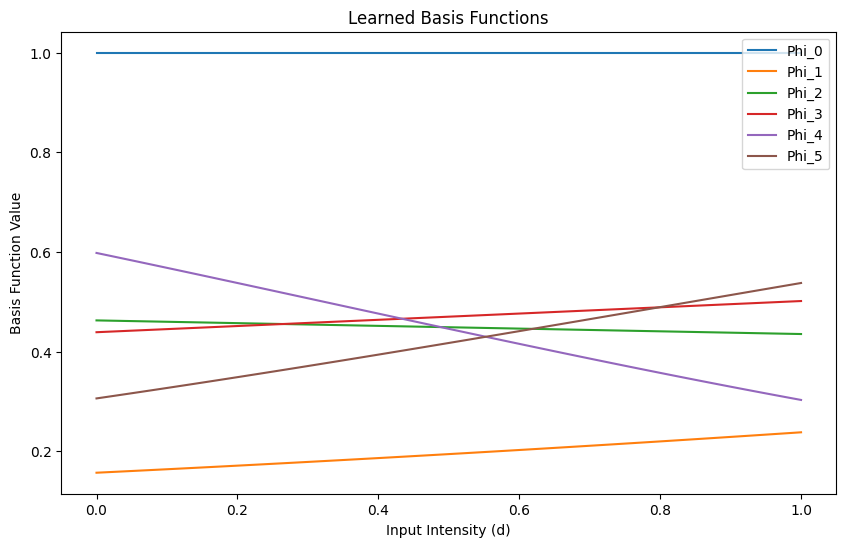

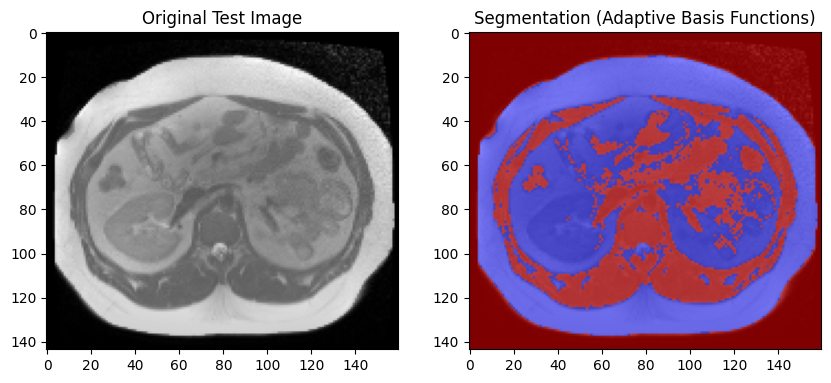

In [10]:
# Adaptive Basis Functions
def adaptive_basis_functions(features, M, beta, intercepts):
    """
    Compute adaptive basis functions of the form:
    phi_0(x) = 1
    phi_m(x) = sigmoid(sum_d beta_m,d * x_d + beta_m,0)
    """
    N = features.shape[0]  # Number of samples
    D = features.shape[1]  # Number of input features

    # Initialize basis functions
    phi = np.zeros((N, M))
    phi[:, 0] = 1  # Constant term (phi_0(x) = 1)

    # Compute phi_m(x) for m > 0
    for m in range(1, M):
        linear_combination = features @ beta[m - 1, :D] + intercepts[m - 1]
        phi[:, m] = 1 / (1 + np.exp(-linear_combination))  # Sigmoid activation

    return phi

# Train logistic regression with adaptive basis functions
def train_logistic_regression_adaptive(TI, TS, M, numIter, vm, noOfSamples):
    """Train logistic regression model with adaptive basis functions."""
    # Extract features from the training image
    featureImage = getInputFeatures(TI, numberOfNeighbors=0)  # Preserve original shape

    # Initialize parameters
    D = featureImage.shape[2]  # Number of input features
    theta = np.zeros(M)  # Logistic regression weights
    beta = np.random.normal(0, 1, (M - 1, D))  # Adaptive parameters (beta_m,d for m > 0)
    intercepts = np.random.normal(0, 1, M - 1)  # Intercepts (beta_m,0 for m > 0)

    # Track cross-entropy history
    cross_entropy_history = []

    for iteration in range(numIter):
        # Get random samples
        x, t, rowAndColNumbers = getSamples(featureImage, TS, noOfSamples)

        # Flatten features to ensure compatibility
        x = x.reshape(noOfSamples, -1)

        # Compute adaptive basis functions for the sampled data
        phi = adaptive_basis_functions(x, M, beta, intercepts)

        # Logistic regression predictions
        a = phi @ theta
        y_pred = 1 / (1 + np.exp(-a))  # Sigmoid

        # Compute cross-entropy loss
        epsilon = 1e-12  # Small value to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        cost = -np.mean(t * np.log(y_pred) + (1 - t) * np.log(1 - y_pred))

        # Gradient for theta
        theta_gradient = phi.T @ (y_pred - t) / noOfSamples

        # Gradients for beta and intercepts
        beta_gradient = np.zeros_like(beta)
        intercepts_gradient = np.zeros_like(intercepts)

        for m in range(1, M):
            sigmoid_grad = phi[:, m] * (1 - phi[:, m])  # Derivative of sigmoid
            beta_gradient[m - 1, :] = np.mean(((y_pred - t)[:, None] * sigmoid_grad[:, None]) * x, axis=0)
            intercepts_gradient[m - 1] = np.mean((y_pred - t) * sigmoid_grad)

        # Update parameters
        theta -= vm * theta_gradient
        beta -= vm * beta_gradient
        intercepts -= vm * intercepts_gradient

        # Store cross-entropy loss
        cross_entropy_history.append(cost)

        # Print progress
        if iteration % 500 == 0:
            print(f"Iteration {iteration}/{numIter}, Cross-Entropy: {cost:.4f}")

    return theta, beta, intercepts, cross_entropy_history

# Train the model with adaptive basis functions
theta_adaptive, beta_adaptive, intercepts_adaptive, cross_entropy_history_adaptive = train_logistic_regression_adaptive(
    TI, TS, M, numIter, vm, noOfSamples
)

# Plot the learned basis functions
x_vals = np.linspace(0, 1, 100).reshape(-1, 1)  # Range of input values
phi_vals = adaptive_basis_functions(x_vals, M, beta_adaptive, intercepts_adaptive)

plt.figure(figsize=(10, 6))
for m in range(M):
    plt.plot(x_vals.flatten(), phi_vals[:, m], label=f"Phi_{m}")
plt.title("Learned Basis Functions")
plt.xlabel("Input Intensity (d)")
plt.ylabel("Basis Function Value")
plt.legend(loc="upper right")
plt.show()

# Segment the test image using the trained adaptive model
def segment_test_image_adaptive(test_image, theta, beta, intercepts, M):
    """Segment the test image using the trained adaptive logistic regression model."""
    test_features = getInputFeatures(test_image, numberOfNeighbors=0)  # Preserve original shape
    test_features_flattened = test_features.reshape(-1, test_features.shape[2])

    # Compute adaptive basis functions for test features
    phi_test = adaptive_basis_functions(test_features_flattened, M, beta, intercepts)

    # Logistic regression predictions
    a_test = phi_test @ theta
    y_pred_test = 1 / (1 + np.exp(-a_test))

    # Reshape predictions into the image shape
    segmentation = (y_pred_test > 0.5).astype(int).reshape(test_image.shape)
    return segmentation

# Perform segmentation on the original test image
test_segmentation_adaptive = segment_test_image_adaptive(TestI, theta_adaptive, beta_adaptive, intercepts_adaptive, M)

# Visualize the original test image and its segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Test Image")
plt.imshow(TestI, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Segmentation (Adaptive Basis Functions)")
plotSeg(TestI, test_segmentation_adaptive)
plt.show()


In task 3 we replaced the fixed cosine basis functions with adaptive ones that adjust during training. This allowed the model to learn features that better fit the data. The adaptive model improved segmentation on the test image and provided smoother, more flexible classification boundaries. We also visualized the learned basis functions, which showed how the model adapted to the data.

## Task 4: Use Neighbour Pixel as second Input Feature

Using the data in the file ```dataForNN_foreBorder_clip1.mat```, re-train and re-apply your classifier, but this time not just based on the intensity in the pixel being classified, but also on that of the pixel in the next row (i.e., the input x is now a vector of dimension $p = 2$). In addition to showing the classifier output on the test image, also include in your report a visualization of the learned basis functions $\phi_m(d)$ in the 2D input space, along with the learned classifier (again in the 2D input space). For the latter, please include a visualization of where the training samples $\{x_i , y_i \}$ are located (cf. the first task).

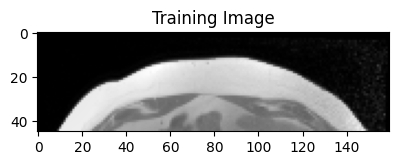

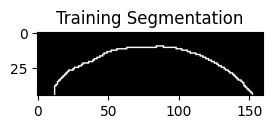

In [11]:
# load the new data
clip1 = np.load('dataForNN_foreBorder_clip1.npy', allow_pickle=True).tolist()

TI_1 = clip1['trainingImage']
TS_1 = clip1['trainingSegmentation']
TestI_1 = clip1['testImage']
TestS_1 = clip1['testSegmentation']

plt.figure(figsize=(10, 5))

# visalize the new data
plt.subplot(1, 2, 1)
plt.imshow(TI_1, cmap='gray')
plt.title('Training Image')
plt.show()

plt.subplot(1, 2, 2)
plt.imshow(TestS_1, cmap='gray')
plt.title('Training Segmentation')
plt.show()

Iteration 0/5000, Cross-Entropy: 0.6931
Iteration 500/5000, Cross-Entropy: 0.4848
Iteration 1000/5000, Cross-Entropy: 0.3935
Iteration 1500/5000, Cross-Entropy: 0.3154
Iteration 2000/5000, Cross-Entropy: 0.2866
Iteration 2500/5000, Cross-Entropy: 0.2718
Iteration 3000/5000, Cross-Entropy: 0.2262
Iteration 3500/5000, Cross-Entropy: 0.2621
Iteration 4000/5000, Cross-Entropy: 0.2208
Iteration 4500/5000, Cross-Entropy: 0.2148


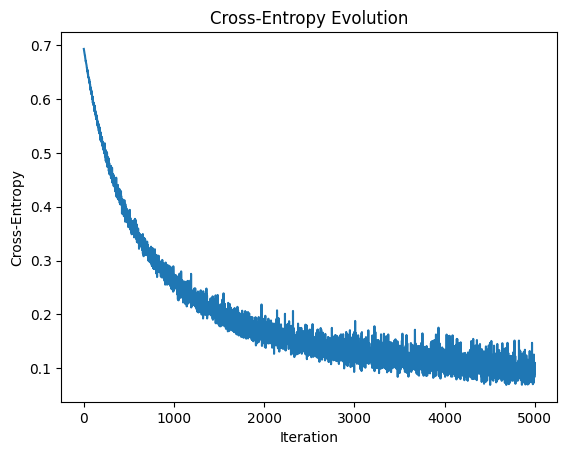

In [12]:
# retrain the model with the new data and bottom pixels
numberOfNeighbors_bottom = 1

# Train the model
theta_1, cross_entropy_history_1, rowAndColNumbers_1, t_1, a_all_1, p_all_1, phi_1, intensity_range_1, x_1 = train_logistic_regression(TI_1, TS_1, M, numberOfNeighbors_bottom, numIter, vm, noOfSamples)

# Plot Cross-Entropy Evolution
plt.plot(cross_entropy_history)
plt.title("Cross-Entropy Evolution")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy")
plt.show()

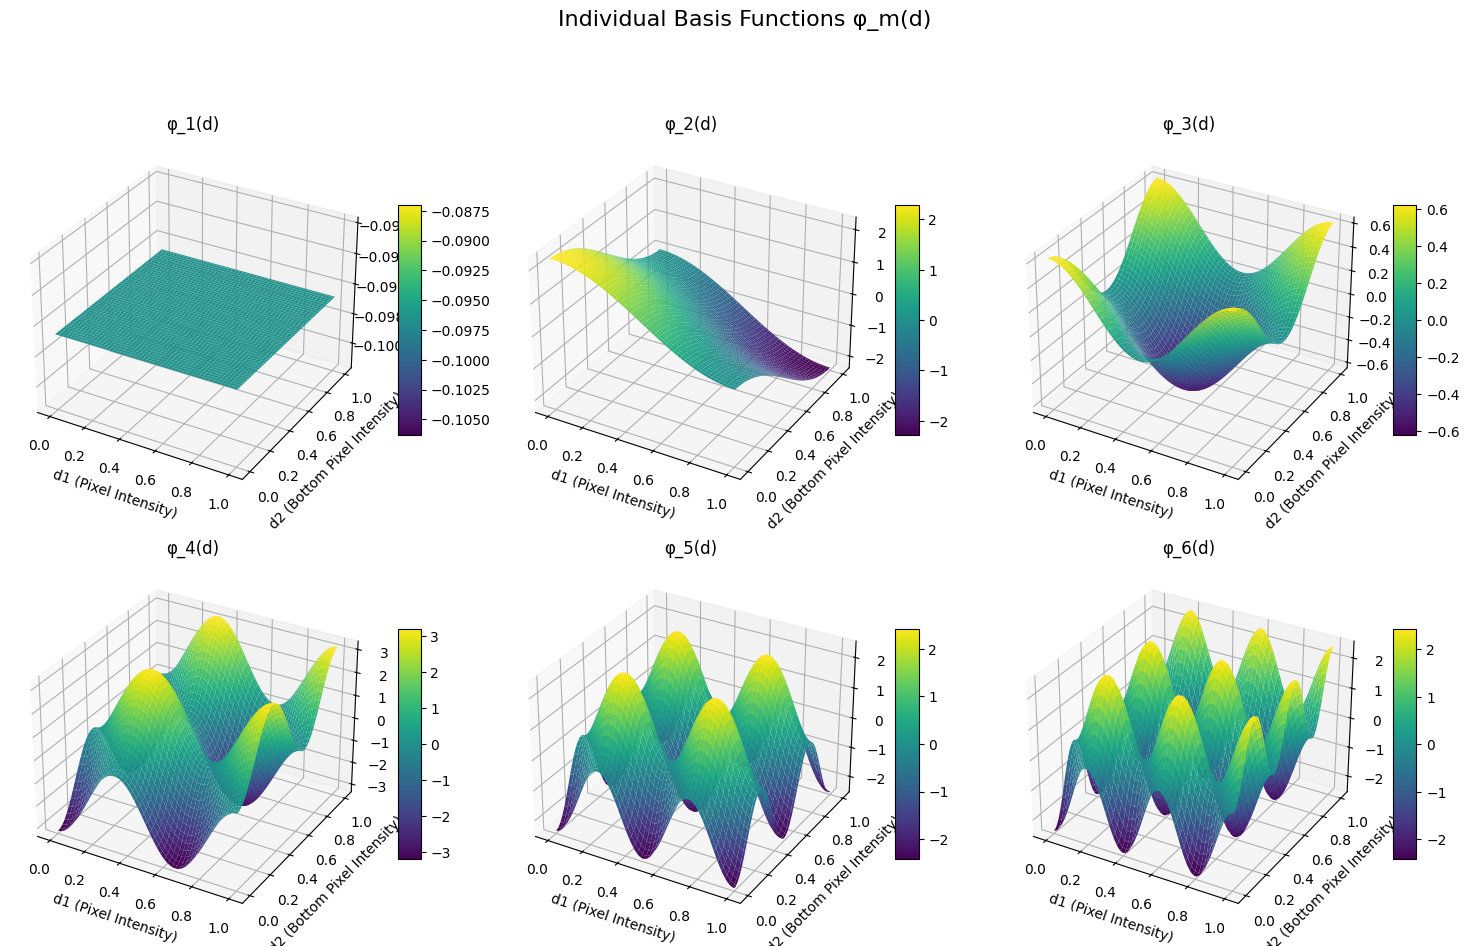

In [13]:
import math

def visualize_individual_2D_basis_functions(theta, M, numFeatures):
    # Reshape theta into M x numFeatures
    theta_reshaped = theta.reshape(M, numFeatures)

    # Define grid range for visualization
    d1_range = np.linspace(0, 1, 100)  # Assuming normalized intensity range [0, 1]
    d2_range = np.linspace(0, 1, 100)
    D1, D2 = np.meshgrid(d1_range, d2_range)
    
    # Flatten grid for basis evaluation
    grid_inputs = np.column_stack([D1.ravel(), D2.ravel()])  # Shape: (10000, 2)

    # Determine number of rows needed
    num_rows = math.ceil(M / 3)

    # Create a figure for the plots
    fig, axes = plt.subplots(num_rows, 3, figsize=(5 * 3, 5 * num_rows),
                             subplot_kw={'projection': '3d'})
    fig.suptitle("Individual Basis Functions φ_m(d)", fontsize=16)

    # Flatten axes for easy indexing
    axes = axes.ravel()

    # Compute and plot each basis function
    for m in range(1, M + 1):
        # Compute φ_m(d) for each grid point
        phi_grid = np.sum(
            np.cos(np.pi * (m - 1) * grid_inputs), axis=1
        )  # Sum over input dimensions
        
        # Compute activation (basis function values for current m)
        activation = phi_grid * theta_reshaped[m - 1].sum()  # Scale by θ_m weights
        
        # Reshape activations to match grid
        activation = activation.reshape(100, 100)

        # Plot the basis function
        ax = axes[m - 1]  # Get the correct subplot
        surf = ax.plot_surface(D1, D2, activation, cmap="viridis", edgecolor="none")
        ax.set_title(f"φ_{m}(d)")
        ax.set_xlabel("d1 (Pixel Intensity)")
        ax.set_ylabel("d2 (Bottom Pixel Intensity)")
        ax.set_zlabel("Activation")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Hide any unused subplots
    for m in range(M, len(axes)):
        axes[m].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust space for the main title
    plt.show()


# Call the visualization function with 2 rows of plots
visualize_individual_2D_basis_functions(theta_1, M=6, numFeatures=numberOfNeighbors_bottom + 1)


Text(0.5, 1.0, 'Segmentation')

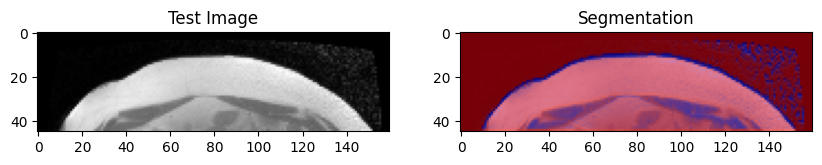

In [14]:
# Perform segmentation on the test image
test_segmentation_1 = segment_test_image(TestI_1, theta_1, M, numberOfNeighbors_bottom)

# plotting
plt.figure(figsize=(10, 5))

# plot of the image
plt.subplot(1, 2, 1)
plt.imshow(TestI_1, cmap='gray')
plt.title("Test Image")

# plot of the segmentation
plt.subplot(1, 2, 2)
plotSeg(TestI_1, test_segmentation_1)
plt.title("Segmentation")

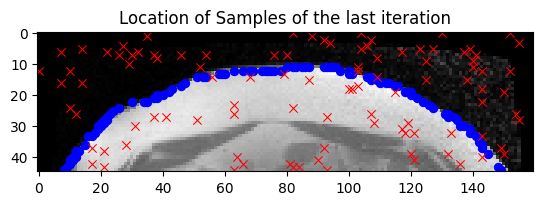

In [15]:
# Show the location of the samples
showLocationOfSamples(TestI_1, rowAndColNumbers_1, t_1)
plt.title("Location of Samples of the last iteration")
plt.show()

In task 4 we expanded the input features by including the intensity of the pixel directly below each pixel in the training image. This added spatial context to the model, improving its segmentation performance. We also visualized the classifier in 2D, showing how it learned to use both the pixel’s intensity and its neighbor’s intensity to make decisions. The segmentation became more accurate and robust compared to using just a single pixel’s intensity.

## Task 5: Use 8 Neighbours as Input Features

Using the data in the file ```dataForNN_foreBorder_clip0.mat```, re-train and re-apply the same classifier, but now using 3 × 3 patches as input, i.e., the input $x$ is now a vector of dimension $p = 9$. In your report you should include the classifier output on the test image, as well as the feature maps and the corresponding model weights $\{ \beta_{m,j} \}^{p}_{j=1}$ as visualized in Fig. 4.5(d) and Fig. 4.5(e), respectively.

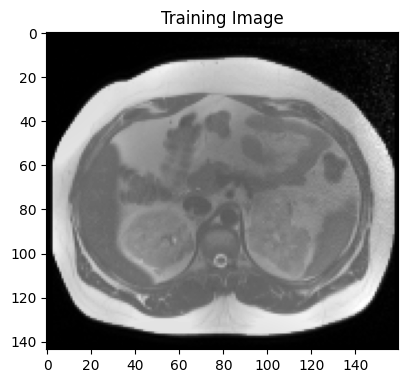

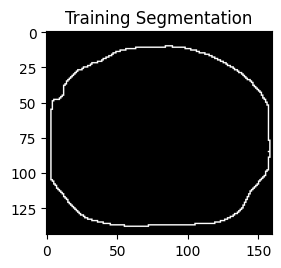

In [16]:
# load new data
clip2 = np.load('dataForNN_foreBorder_clip0.npy', allow_pickle=True).tolist()

TI_2 = clip2['trainingImage']
TS_2 = clip2['trainingSegmentation']
TestI_2 = clip2['testImage']
TestS_2 = clip2['testSegmentation']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(TI_2, cmap='gray')
plt.title('Training Image')
plt.show()

plt.subplot(1, 2, 2)
plt.imshow(TestS_2, cmap='gray')
plt.title('Training Segmentation')
plt.show()

Iteration 0/5000, Cross-Entropy: 0.6931
Iteration 500/5000, Cross-Entropy: 0.3938
Iteration 1000/5000, Cross-Entropy: 0.3365
Iteration 1500/5000, Cross-Entropy: 0.3026
Iteration 2000/5000, Cross-Entropy: 0.2640
Iteration 2500/5000, Cross-Entropy: 0.2742
Iteration 3000/5000, Cross-Entropy: 0.2250
Iteration 3500/5000, Cross-Entropy: 0.1977
Iteration 4000/5000, Cross-Entropy: 0.1750
Iteration 4500/5000, Cross-Entropy: 0.2200


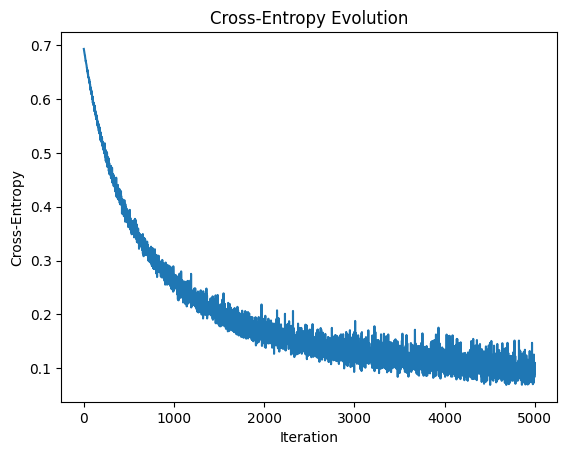

In [17]:
# retrain the model with the new data and number of neighbors = 8
numberOfNeighbors_2 = 8

# Train the model
theta_2, cross_entropy_history_2, rowAndColNumbers_2, t_2, a_all_2, p_all_2, phi_2, intensity_range_2, x_2 = train_logistic_regression(TI_2, TS_2, M, numberOfNeighbors_2, numIter, vm, noOfSamples)

# Plot Cross-Entropy Evolution
plt.plot(cross_entropy_history)
plt.title("Cross-Entropy Evolution")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy")
plt.show()

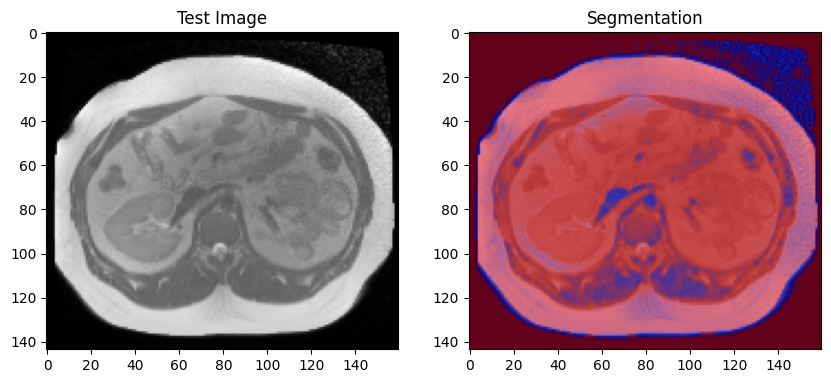

In [18]:
# plot segmentation of the test image
test_segmentation_2 = segment_test_image(TestI_2, theta_2, M, numberOfNeighbors_2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Test Image")
plt.imshow(TestI_2, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Segmentation")
plotSeg(TestI_2, test_segmentation_2)
plt.show()

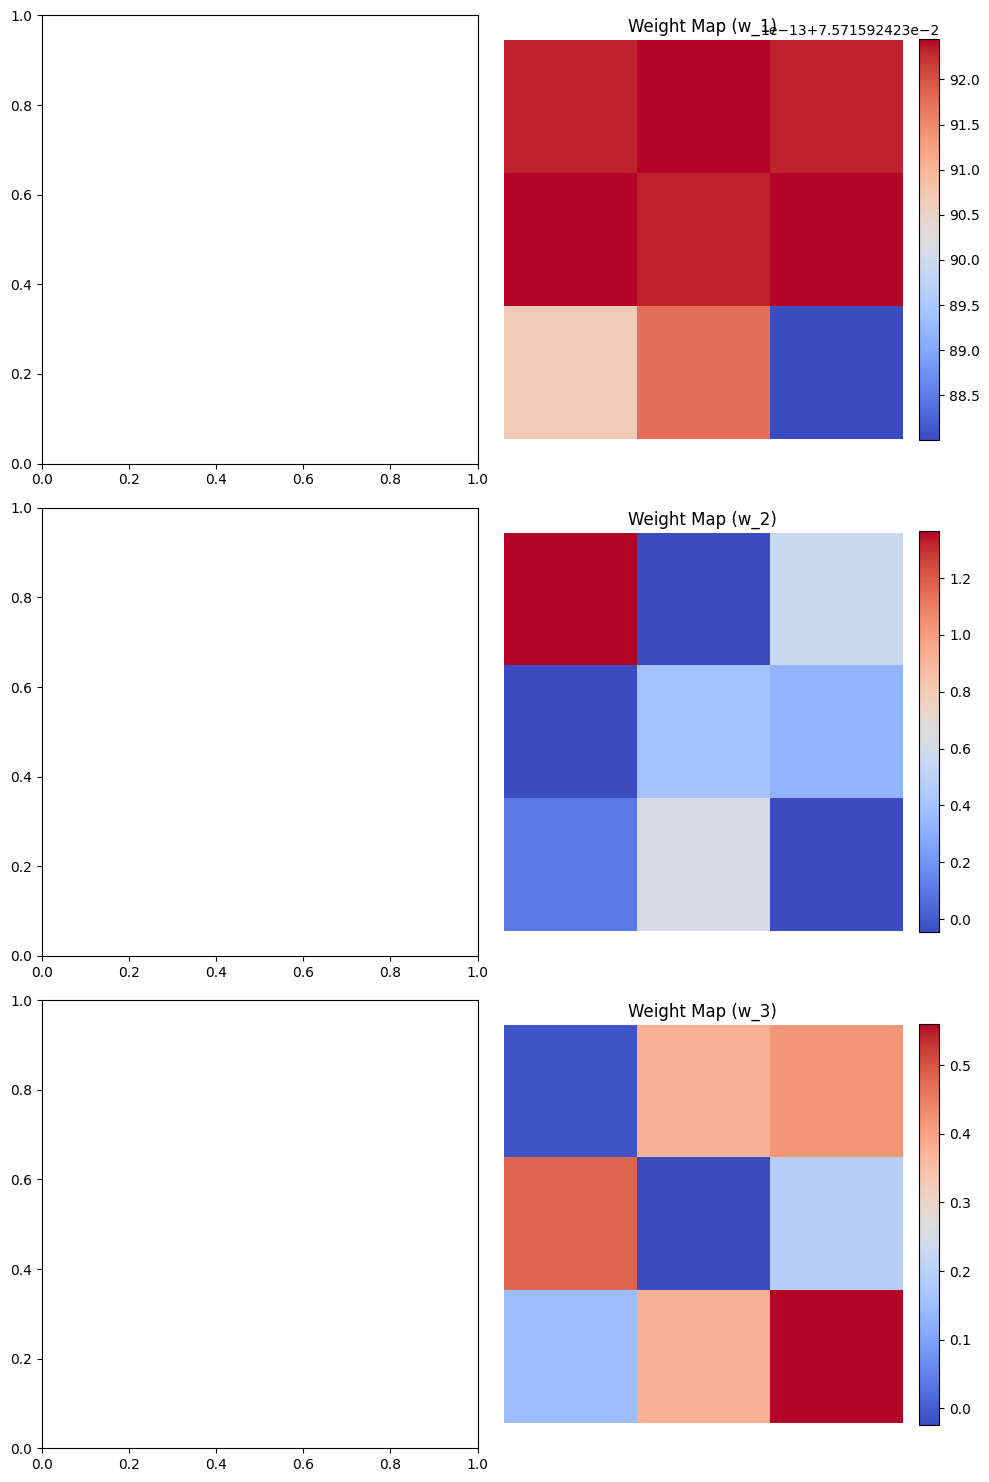

In [23]:
def visualize_feature_maps_and_weights(phi, theta, image_shape, patch_size, num_features):
    fig, axes = plt.subplots(num_features, 2, figsize=(10, 5 * num_features))
    num_patches = patch_size * patch_size  # Total number of pixels in a patch
    
    for m in range(num_features):
        # Extract the feature map (f_m(x)) from the design matrix
        # feature_map = phi[:, m].reshape(image_shape)  # Reshape to original image size
        
        # Extract the weights (w_{m,d}) for this feature
        weights_m = theta[m * num_patches:(m + 1) * num_patches]
        weights_patch = weights_m.reshape((patch_size, patch_size))  # Reshape to patch size

        # Plot the feature map
        # ax_feature_map = axes[m, 0]
        # ax_feature_map.imshow(feature_map, cmap="coolwarm", interpolation="nearest")
        # ax_feature_map.set_title(f"Feature Map (f_{m+1}(x))")
        # ax_feature_map.axis("off")
        
        # Plot the weights as a 3x3 patch
        ax_weight_map = axes[m, 1]
        weight_plot = ax_weight_map.imshow(weights_patch, cmap="coolwarm", interpolation="nearest")
        ax_weight_map.set_title(f"Weight Map (w_{m+1})")
        ax_weight_map.axis("off")
        
        # Add a color bar for the weight map
        fig.colorbar(weight_plot, ax=ax_weight_map, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming train_logistic_regression produces theta and phi (design matrix)
H, W = 144, 160  # Example image shape
patch_size = 3
num_features = 3  # Number of basis functions

visualize_feature_maps_and_weights(phi_2, theta_2, (H, W), patch_size, num_features)


We were not able to correctly plot the feature maps based on the weigths. But the task involves modifying an existing classification pipeline to work with 3×3 patches (i.e., small sub-regions) of the input image rather than single pixel intensities. The goal is to adapt the classifier to use feature vectors of size 
p=9 (corresponding to the 9 pixels in each patch), retrain it on the provided dataset, and evaluate its performance. Since we are not able to obtain the proper outputs it is difficult to evaluate the performance.

# Conclusion

This task studied and applied a neural network approach to image segmentation with binary pixel-wise classification as foreground of background. Through the stepwise addition of the design changes, the study illustrated how different elements impact segmentation performance. These ranged from the use of fixed or adaptive basis functions, robustness to intensity transformations and taking into account spatial context via neighboring pixel intensities and larger input patches.

Despite all this, the final task, which was more complex, also did not end up being completed, where we could have explored more enhancements and visualizations of the learned feature maps and weights.

In summary, the results demonstrate the importance of feature representation, spatial awareness, and model flexibility in enhancing the accuracy of segmentation. The lessons learnt offer a solid basis for continued exploration and unfinished work.